In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('all')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import pkg_resources
from symspellpy import SymSpell, Verbosity

from unidecode import unidecode

from bs4 import BeautifulSoup

import contractions
import re
import string


import warnings
warnings.filterwarnings("ignore")
import requests


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/luqman/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package paradigms is already up-to-date!
[nltk_data]    | Downloading package pe08 to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package pe08 is already up-to-date!
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package perluniprops is alre

[nltk_data]    |   Package wordnet2022 is already up-to-date!
[nltk_data]    | Downloading package wordnet31 to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /Users/luqman/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luqman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luqman/nltk_data...
[nltk_data]   Packag

please ensure that your csv is in the same location as this notebook before trying to read in the data.

In [2]:
data = pd.read_csv("ProspleAU_data_i.csv")

### Data Pre-Processing

In [3]:
data.isnull().sum()

Job Title          0
Company            0
Job Brief          0
Deadline Date      3
Job Description    1
dtype: int64

In [4]:
df = data.drop(columns='Deadline Date')

In [5]:
df.dropna(inplace=True)

In [6]:
df_analysis = df[['Job Brief' , 'Job Description']]

#### Textual Processing

In [7]:
def normalize_abbreviations(text):
    matches = re.finditer(r"([A-Z]\.)+", text)
    matched_abbr = [match.group() for match in matches]
    for abbr in matched_abbr:
        text = re.sub(abbr,abbr.replace(".",""), text)
    return text

In [8]:
df = df_analysis.copy()
df['Job Brief'] = df['Job Brief'].apply(normalize_abbreviations)
df['Job Description'] = df['Job Description'].apply(normalize_abbreviations)

In [9]:
#Remove Punctuation
punct_to_keep = ["&"]
punct_to_remove = "".join(punct for punct in string.punctuation if punct not in punct_to_keep)
def handle_punctuations(text):
    text = re.sub('[%s]' % re.escape(punct_to_remove), " ",text)
    for punct in punct_to_keep:
        text = re.sub(f"{punct}", f" {punct} ",text)
    return text

In [10]:
def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

In [11]:
df['Job Brief'] = df['Job Brief'].apply(clean_numbers)
df['Job Description'] = df['Job Description'].apply(clean_numbers)

In [12]:
# Preparation
# For HTML removal with regex
HTML_ENTITIES = ["</\w+>", "<\w+>", "&nbsp;", "&lt;", "&gt;", "&amp;", "&quot;", 
                 "&apos;", "&cent;", "&pound;", "&yen;", "&euro;", "&copy;", "&reg;",]

# For Stopwords
stop_words = set(stopwords.words('english'))

# For Lemmatization
lemmatizer = WordNetLemmatizer()

# For symspellpy
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# For Britisize
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
american_to_british_dict = requests.get(url).json()

# For Americanize
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_dict = requests.get(url).json()

In [13]:
def text_preprocessing(text):
    text = text.lower() # Lower
    for entity in HTML_ENTITIES: # Remove HTML
        text = re.sub(f"{entity}", " ", text)
    text = contractions.fix(text) # Expand contractions
    text = re.sub(re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?'), "", text) # Remove URL
    text = re.sub(re.compile(r"[\w\.-]+@[\w\.-]+\.\w+"), "", text) # Remove email
    text = unidecode(text) # Handle accented words
    text = text.encode("ascii", "ignore").decode() # Remove Unicode characters
    text = handle_punctuations(text)  # Remove Punctuations
    text = re.sub(re.compile("\w*\d+\w*"), "",text) # Remove digits and words with digits
# #     text = re.sub(re.compile("[^A-Za-z0-9]"), " ", text)   # Remove Punctuations
# #     text = re.sub(re.compile("[^A-Za-z]"), " ", text)   # Remove Punctuations and digits
    text = " ".join([word for word in str(text).split() if word not in stop_words]) # Remove stopwords
    text = re.sub(' +', ' ', text).strip()  # Remove extra space
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatization
    text = " ".join([sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term for word in text.split()]) # Spelling correction
    text = " ".join([sym_spell.lookup_compound(word, max_edit_distance=2)[0].term for word in text.split()]) # Compound word correction
    text = " ".join([word for word in str(text).split() if word not in stop_words]) # Final stopwords removal
    text = " ".join([american_to_british_dict[word] if word in american_to_british_dict else word for word in text.split()]) # Britisize
    text = " ".join([british_to_american_dict[word] if word in british_to_american_dict else word for word in text.split()]) #Americanize
    return text

In [14]:
df['Job Brief'] = df['Job Brief'].apply(text_preprocessing)
df['Job Description'] = df['Job Description'].apply(text_preprocessing)

In [15]:
df.sample(5, random_state=1)

,Job Brief,Job Description
50,engineering efficiency sustaining progress beg...,actions graduate program come join building in...
2,finished degree sure next competitive nature a...,wondering future insure graduate program could...
35,graduate undertake variety technical professio...,sra graduate program exciting challenging rewa...
48,two year program graduate undertake two month ...,experience opportunity global business offer d...
39,ready set sail career journey part australia l...,austral austral graduate development program o...


### EDA - Word Distribution

In [16]:
from collections import Counter

In [17]:
def count_word_frequency(textlist):
    word_frequency = Counter()
    
    # Iterate through each text in the list
    for text in textlist:
        # Use regex to find all words in the text
        words = re.findall(r'\w+', text.lower())  # Assuming words are separated by spaces
        
        # Update word frequency counter
        word_frequency.update(words)
    
    return word_frequency

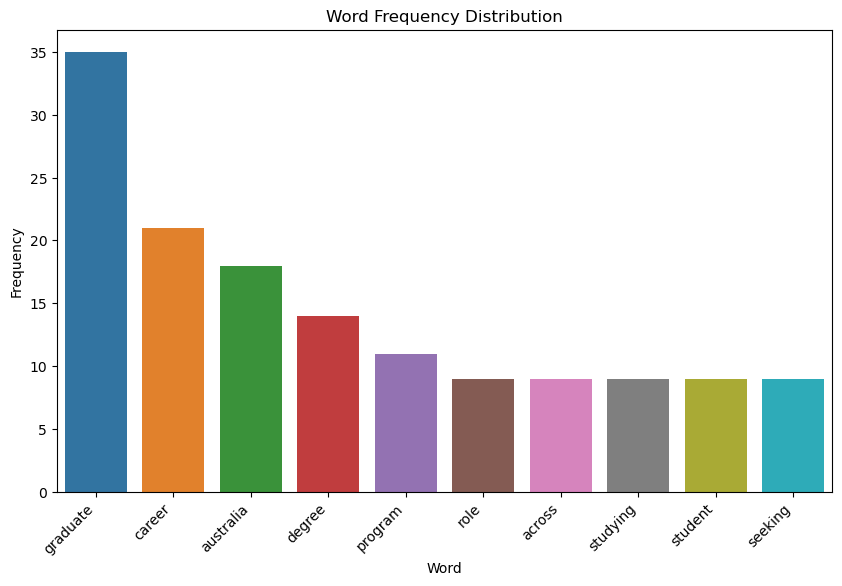

In [20]:
brief_freq = count_word_frequency(df['Job Brief'])

brief_freq_df = pd.DataFrame.from_dict(brief_freq, orient='index').reset_index()
brief_freq_df.columns = ['Word', 'Frequency']

brief_freq_df = brief_freq_df.sort_values(by='Frequency', ascending=False)
brief_freq_df = brief_freq_df[brief_freq_df['Frequency'] > 3]

top_10_words = brief_freq_df.head(10)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top_10_words)
plt.xticks(rotation=45, ha='right')
plt.title('Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()


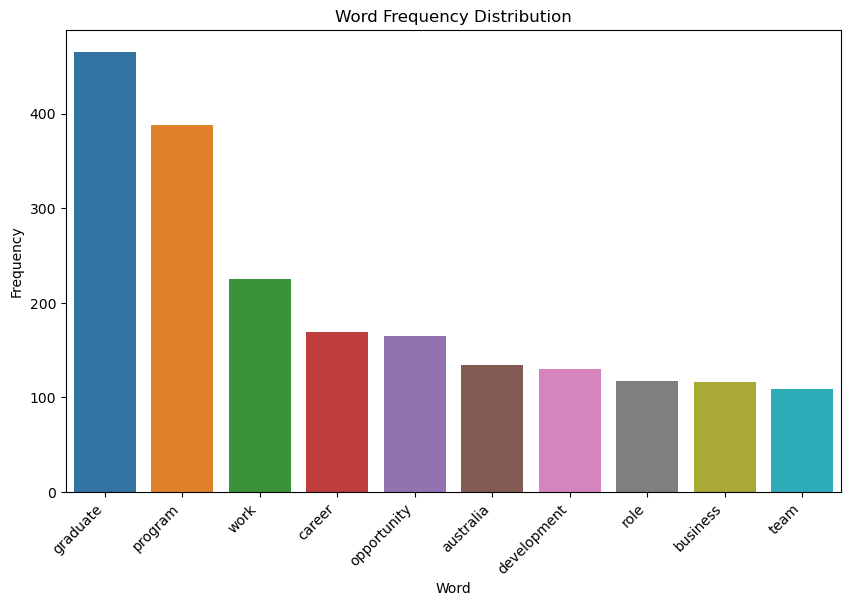

In [22]:
desc_freq = count_word_frequency(df['Job Description'])

desc_freq_df = pd.DataFrame.from_dict(desc_freq, orient='index').reset_index()
desc_freq_df.columns = ['Word', 'Frequency']

desc_freq_df = desc_freq_df.sort_values(by='Frequency', ascending=False)
desc_freq_df = desc_freq_df[desc_freq_df['Frequency'] > 75]

top_10_words = desc_freq_df.head(10)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top_10_words)
plt.xticks(rotation=45, ha='right')
plt.title('Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

#### Sentiment Analysis using Textblob

In [ ]:
#To get subjectivity and polarity, import textblob
from textblob import TextBlob

In [ ]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getComputation(score):
    if score < -0.5:
        return 'Very Negative'
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'


df['Subjectivity - Brief'] = df['Job Brief'].apply(getSubjectivity)
df['Subjectivity - Desc'] = df['Job Description'].apply(getSubjectivity)
df['Polarity - Brief'] = df['Job Brief'].apply(getPolarity)
df['Polarity - Desc'] = df['Job Description'].apply(getPolarity)
df['Sentiment - Brief'] = df['Polarity - Brief'].apply(getComputation)
df['Sentiment - Desc'] = df['Polarity - Desc'].apply(getComputation)

In [ ]:
# Plot value counts for 'Sentiment - Brief' and 'Sentiment - Desc' side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 'Sentiment - Brief'
sns.countplot(data=df, x='Sentiment - Brief', order=['Very Negative', 'Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_title('Sentiment - Brief Value Counts')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Plot for 'Sentiment - Desc'
sns.countplot(data=df, x='Sentiment - Desc', order=['Very Negative', 'Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_title('Sentiment - Desc Value Counts')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### EDA - Identifying key words

#### Statistical Approaches (TF-IDF/RAKE)

TF-IDF is a statistical measure that can be split into 2 parts: 
- TF (Term Frequency) looks at the frequency of a particular term you are concerned with.
- IDF (Inverse Document Frequency) basically identifies how common (or uncommon) a word is amongst the corpus. We do this as we use connectors freq in English Language.

We combine the two to find the importance of a term inversely related to its frequency.

In [24]:
# Keyword Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Job Description'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Find the top keywords for each job description
top_keywords = []
for idx, text in enumerate(df['Job Description']):
    # Get the TF-IDF scores for each word in the text
    tfidf_scores = tfidf_df.iloc[idx]
    # Sort the scores in descending order
    sorted_tfidf_scores = tfidf_scores.sort_values(ascending=False)
    # Get the top 5 keywords
    top_keywords.append(', '.join(sorted_tfidf_scores.head(5).index.tolist()))

# Create a DataFrame with job descriptions and corresponding keywords
keywords_df = pd.DataFrame({'Job Description': df['Job Description'], 'Keywords': top_keywords})


In [25]:
keywords_df.head(10)

,Job Description,Keywords
0,join come aboard excited challenge ease workin...,"colleague, consultant, impact, interesting, cl..."
1,wondering future insure graduate program could...,"industry, financial, face, interview, graduate"
2,wondering future insure graduate program could...,"industry, financial, face, interview, graduate"
3,wondering future insure graduate program could...,"insurance, industry, insure, face, interview"
4,finished degree sure next looking first step c...,"industry, mortgage, face, interview, loan"
5,need graduate willingness learn good attitude ...,"queensland, government, program, agency, reloc..."
6,wondering future insure graduate program could...,"insurance, underwriter, industry, face, interview"
7,policy future graduate get explore wide range ...,"policy, queensland, impact, explore, emergency"
8,first nation career pathway role advertised ta...,"policy, queensland, diverse, impact, queenslander"
9,role register apply queensland treasury gradua...,"treasury, queensland, government, analyst, eco..."


However it has limitations:

- It does not take into account semantic meaning. It assigns numerical weights on different words.
- ignores word order and thus compound nouns like “Queen of England” will not be considered as a single unit. Can be overcome by underscores eg:("queen_of_england").

Hence it probably would not be the most useful in identifying Key Skills in each job description. To do so, we need to use more accurate methods to generate Key Skills.

#### 1ii. An ML approach - Classification using Naive Bayes   
We can potentially employ classification by aggregating job titles together, and then extract the most important features from each class. However, chose not to go down this approach due to having different jobs in different industries. 

For further ref: https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-descriptions

#### 2. Fundamental NLP approaches (Supervised Learning)

we begin with the basic natural language processing techniques using the `spaCy` library (can also be done with `NLTK` library). To extract key skills, we take our preprocessed textual data and run through the following steps:
- 1.) P-O-S Tagging - A technique to identify nouns and adjectives; skills and desirables traits are represented with these lexical categories
- 2.) Named Entity Recognition - A technique to identify places, names, countries which we will subsequently drop

we hope that the combination of these 2 methods will allow us to identify desirable attributes within the processed job descriptions. 


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_skills(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    # Initialize a set to store unique tokens
    unique_tokens = set()
    
    # Initialize a set to store named entities to be dropped
    named_entities = set()
    
    # Loop through each token in the document
    for token in doc:
        # Check if the token is not a stop word and is either a noun or an adjective
        if not token.is_stop and (token.pos_ == "NOUN" or token.pos_ == "ADJ"):
            # Add the token to the set of unique tokens
            unique_tokens.add(token)
        
        # Check if the token is a named entity (NER)
        if token.ent_type_ != "":
            # Add the named entity to the set of named entities
            named_entities.add(token)
    
    # Remove named entities from the set of unique tokens
    unique_tokens.difference_update(named_entities)
    
    # Return the set of unique tokens (skills)
    return list(unique_tokens)

keywords_df = pd.DataFrame({'Job Description': df['Job Description'], 'Keywords': df['Job Description'].apply(extract_skills)})

In [ ]:
keywords_df.sample(5, random_state=42)

#### 2ii Unsupervised Learning (GloVe algorithm)

#### 3 Transformers
Literature has identified transformer models as tools that surpass previous methods of NLP 